## **Film Trends and Business Recommendations**
### Background
The entertainment industry has seen a massive shift toward original video content, with streaming platforms and traditional studios investing billions in film production. For a company looking to establish a new movie studio, understanding current market trends is crucial to making informed decisions about what types of films to produce.

Historically, successful films depend on multiple factors, including:

* Genre preferences (e.g., superhero films dominating box offices)

* Production budgets (blockbusters vs. low-budget successes)

* Release timing (summer blockbusters, holiday season hits)

* Critical reception (how ratings influence financial performance)

* Star power (impact of directors and lead actors)

### Business Problem

Our company aims to launch a new movie studio but lacks expertise in film production. To maximize success, we need data-driven insights on:

1. Which genres generate the highest revenue and return on investment (ROI)?

2. What budget range is optimal for different film types?

3. When is the best time to release a movie for maximum earnings?

4. Does critical acclaim (e.g., IMDb/Rotten Tomatoes ratings) correlate with box office success?



### Getting started on the analysis 

We start by importing the necessary libraries to help with the analysis.

In [103]:

import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
import io
import base64
warnings.filterwarnings('ignore')

import pickle

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)



In [102]:
# DATABASE CONNECTION AND LOADING

def load_imdb_data(db_path='im.db'):
    conn = sqlite3.connect(db_path)
    
    imdb_tables = {}
    table_names = ['movie_basics', 'directors', 'known_for', 'movie_akas', 
                   'movie_ratings', 'persons', 'principals', 'writers']
    
    for table in table_names:
        try:
            imdb_tables[table] = pd.read_sql_query(f"SELECT * FROM {table}", conn)
            print(f"✓ {table}: {imdb_tables[table].shape}")
            
        except Exception as e:
            print(f"✗ {table}: {e}")
            
    conn.close()       
    return imdb_tables


### Reading the data from the various sources 


In [101]:
try:
    
    imdb_data = load_imdb_data()
    
    bom_df = pd.read_csv('bom.movie_gross.csv')
    print(f"Box Office Mojo data loaded: {bom_df.shape}")
    
    rt_info_df = pd.read_csv('rt.movie_info.tsv', sep='\t')
    print(f"RT Movie Loaded: {rt_info_df.shape}")

    rt_reviews_df = pd.read_csv('rt.reviews.tsv', sep='\t', encoding='latin1')  
    print(f"RT Reviews Loaded: {rt_reviews_df.shape}")

    tmdb_df = pd.read_csv('tmdb.movies.csv')
    print(f"TMDB data loaded: {tmdb_df.shape}")

    tn_budget_df = pd.read_csv('tn.movie_budgets.csv')
    print(f"Budget Loaded: {tn_budget_df.shape}")

except FileNotFoundError as e:
    print(f"Error loading file: {e}")
except UnicodeDecodeError as e:
    print(f"Encoding error: {e}")

datasets = {
    'Box Office Mojo': bom_df,
    'RT Movie Info': rt_info_df,
    'RT Reviews': rt_reviews_df,
    'TMDB Movies':tmdb_df,
    'Budget Data': tn_budget_df
}

datasets.update({f'IMDb {k}': v for k, v in imdb_data.items()})



✓ movie_basics: (146144, 6)
✓ directors: (291174, 2)
✓ known_for: (1638260, 2)
✓ movie_akas: (331703, 8)
✓ movie_ratings: (73856, 3)
✓ persons: (606648, 5)
✓ principals: (1028186, 6)
✓ writers: (255873, 2)
Box Office Mojo data loaded: (3387, 5)
RT Movie Loaded: (1560, 12)
RT Reviews Loaded: (54432, 8)
TMDB data loaded: (26517, 10)
Budget Loaded: (5782, 6)


In [ ]:
# DATA CLEANING AND PREPROCESSING

print("\n\n3. DATA CLEANING AND PREPROCESSING")

print("Cleaning Box Office Mojo data...")
bom_clean = bom_df.copy()

if 'domestic_gross' in bom_clean.columns:
    bom_clean['domestic_gross'] = pd.to_numeric(bom_clean['domestic_gross'], errors='coerce')
if 'foreign_gross' in bom_clean.columns:
    bom_clean['foreign_gross'] = pd.to_numeric(bom_clean['foreign_gross'], errors='coerce')

print("Cleaning Budget Data")
tn_clean = tn_budget_df.copy()

budget_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in budget_cols:
    if col in tn_clean.columns:

        tn_clean[col] = tn_clean[col].astype(str).str.replace('$', '').str.replace(',', '')
        tn_clean[col] = pd.to_numeric(tn_clean[col], errors='coerce')

print("Cleaning TMDB data...")
tmdb_clean = tmdb_df.copy()

if 'release_date' in tmdb_clean.columns:
    tmdb_clean['release_date'] = pd.to_datetime(tmdb_clean['release_date'], errors='coerce')
    tmdb_clean['release_year'] = tmdb_clean['release_date'].dt.year

print("Cleaning Rotten Tomatoes data...")
rt_clean = rt_info_df.copy()

if 'rating' in rt_clean.columns:
    rt_clean['rating_numeric'] = pd.to_numeric(rt_clean['rating'], errors='coerce')
    
    
imdb_clean = {}
if imdb_data:
    if 'movie_basics' in imdb_data:
        imdb_clean['movie_basics'] = imdb_data['movie_basics'].copy()
        imdb_clean['movie_basics']['start_year'] = pd.to_numeric(
            imdb_data['movie_basics']['start_year'], errors='coerce'
        )
        imdb_clean['movie_basics']['runtime_minutes'] = pd.to_numeric(
            imdb_data['movie_basics']['runtime_minutes'], errors='coerce'
        )
        
    if 'movie_ratings' in imdb_data:
        imdb_clean['movie_ratings'] = imdb_data['movie_ratings'].copy()
        imdb_clean['movie_ratings']['averagerating'] = pd.to_numeric(
            imdb_data['movie_ratings']['averagerating'], errors='coerce'
        )
        imdb_clean['movie_ratings']['numvotes'] = pd.to_numeric(
            imdb_data['movie_ratings']['numvotes'], errors='coerce'
        )
    
    for table in ['directors', 'principals', 'persons']:
        if table in imdb_data:
            imdb_clean[table] = imdb_data[table].copy()
            
# print("TMDB Clean Columns:", tmdb_clean.columns.tolist())


print("Data Cleaning completed")



3. DATA CLEANING AND PREPROCESSING
Cleaning Box Office Mojo data...
Cleaning Budget Data
Cleaning TMDB data...
Cleaning Rotten Tomatoes data...
TMDB Clean Columns: ['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count', 'release_year']
Data Cleaning completed


In [99]:
# EXPLANATORY DATA ANALYSIS

def create_comprehensive_analysis():
    """Create comprehensive analysis combining all data sources"""
    
    fig = plt.figure(figsize=(20, 24))
    gs = GridSpec(6, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    fig.suptitle('Comprehensive Movie Market Analysis', 
                 fontsize=20, fontweight='bold', y=0.98)
    
    ax1 = fig.add_subplot(gs[0, 0])
    if 'worldwide_gross' in tn_clean.columns and 'movie' in tn_clean.columns:
        top_movies = tn_clean.nlargest(10, 'worldwide_gross')
        bars = ax1.barh(range(len(top_movies)), top_movies['worldwide_gross']/1e9)
        ax1.set_yticks(range(len(top_movies)))
        ax1.set_yticklabels(top_movies['movie'], fontsize=8)
        ax1.set_xlabel('Worldwide Gross (Billions $)')
        ax1.set_title('Top 10 Highest Grossing Movies')
        ax1.invert_yaxis()
        
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax1.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                    f'${width:.1f}B', ha='left', va='center', fontsize=8)
    
    ax2 = fig.add_subplot(gs[0, 1])
    if 'production_budget' in tn_clean.columns and 'worldwide_gross' in tn_clean.columns:
        budget_revenue = tn_clean[['production_budget', 'worldwide_gross']].dropna()
        budget_revenue = budget_revenue[
            (budget_revenue['production_budget'] > 0) &
            (budget_revenue['worldwide_gross'] > 0)
        ]
        
        budget_revenue['roi'] = budget_revenue['worldwide_gross'] / budget_revenue['production_budget']
        
        scatter = ax2.scatter(budget_revenue['production_budget'] / 1e6,
                             budget_revenue['worldwide_gross'] / 1e6,
                             c=budget_revenue['roi'], cmap='viridis', 
                             alpha=0.6, s=50)
        ax2.set_xlabel('Production Budget (Millions $)')
        ax2.set_ylabel('Worldwide Gross (Millions $)')
        ax2.set_title("Budget vs Revenue (colored by ROI)")
        
        max_val = max(budget_revenue['production_budget'].max(),
                      budget_revenue['worldwide_gross'].max()) / 1e6
        ax2.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Break-even')
        ax2.legend()
        
        plt.colorbar(scatter, ax=ax2, label='ROI')
    
    ax3 = fig.add_subplot(gs[0, 2])
    if 'movie_ratings' in imdb_clean:
        ratings = imdb_clean['movie_ratings']['averagerating'].dropna()
        ax3.hist(ratings, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax3.axvline(ratings.mean(), color='red', linestyle='--', 
                   label=f'Mean: {ratings.mean():.2f}')
        ax3.axvline(ratings.median(), color='orange', linestyle='--', 
                   label=f'Median: {ratings.median():.2f}')
        ax3.set_xlabel('IMDb Rating')
        ax3.set_ylabel('Number of Movies')
        ax3.set_title('Distribution of IMDb Ratings')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    ax4 = fig.add_subplot(gs[1, :])
    if 'movie_basics' in imdb_clean:
        movie_basics = imdb_clean['movie_basics'].dropna(subset=['genres'])
        
        all_genres = []
        for genres_str in movie_basics['genres']:
            if isinstance(genres_str, str) and genres_str != '\\N':
                genres = genres_str.split(',')
                all_genres.extend([g.strip() for g in genres])
        
        genre_counts = pd.Series(all_genres).value_counts().head(15)
        
        bars = ax4.bar(range(len(genre_counts)), genre_counts.values)
        ax4.set_xticks(range(len(genre_counts)))
        ax4.set_xticklabels(genre_counts.index, rotation=45, ha='right')
        ax4.set_ylabel('Number of Movies')
        ax4.set_title('Most Popular Genres in IMDb Database')
        ax4.grid(True, alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 50,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    ax5 = fig.add_subplot(gs[2, 0])
    if 'movie_basics' in imdb_clean:
        runtime_data = imdb_clean['movie_basics']['runtime_minutes'].dropna()
        runtime_data = runtime_data[(runtime_data >= 30) & (runtime_data <= 300)]
        
        ax5.hist(runtime_data, bins=40, alpha=0.7, color='lightgreen', edgecolor='black')
        ax5.axvline(runtime_data.mean(), color='red', linestyle='--', 
                   label=f'Mean: {runtime_data.mean():.0f} min')
        ax5.axvline(runtime_data.median(), color='orange', linestyle='--', 
                   label=f'Median: {runtime_data.median():.0f} min')
        ax5.set_xlabel('Runtime (Minutes)')
        ax5.set_ylabel('Number of Movies')
        ax5.set_title('Movie Runtime Distribution')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    
    ax6 = fig.add_subplot(gs[2, 1])
    if 'movie_ratings' in imdb_clean:
        ratings_df = imdb_clean['movie_ratings'].dropna()
        ratings_df = ratings_df[ratings_df['numvotes'] >= 100]
        
        scatter = ax6.scatter(ratings_df['numvotes'], ratings_df['averagerating'], 
                             alpha=0.5, s=30)
        ax6.set_xscale('log')
        ax6.set_xlabel('Number of Votes (log scale)')
        ax6.set_ylabel('Average Rating')
        ax6.set_title('Rating vs Number of Votes')
        ax6.grid(True, alpha=0.3)
        
        log_votes = np.log10(ratings_df['numvotes'])
        z = np.polyfit(log_votes, ratings_df['averagerating'], 1)
        p = np.poly1d(z)
        ax6.plot(ratings_df['numvotes'], p(log_votes), "r--", alpha=0.8)
    
    ax7 = fig.add_subplot(gs[2, 2])
    if 'movie_basics' in imdb_clean:
        year_data = imdb_clean['movie_basics']['start_year'].dropna()
        year_data = year_data[(year_data >= 1990) & (year_data <= 2023)]
        year_counts = year_data.value_counts().sort_index()
        
        ax7.plot(year_counts.index, year_counts.values, marker='o', linewidth=2)
        ax7.set_xlabel('Release Year')
        ax7.set_ylabel('Number of Movies')
        ax7.set_title('Movie Production Trends (1990-2023)')
        ax7.grid(True, alpha=0.3)
        ax7.tick_params(axis='x', rotation=45)
    
    ax8 = fig.add_subplot(gs[3, :2])
    if 'movie_ratings' in imdb_clean and 'rating_numeric' in rt_clean.columns:
        
        imdb_ratings = imdb_clean['movie_ratings']['averagerating'].dropna()
        rt_ratings = rt_clean['rating_numeric'].dropna()
        
        ax8.hist(imdb_ratings, bins=30, alpha=0.6, label='IMDb Ratings', 
                color='blue', density=True)
        ax8.hist(rt_ratings, bins=30, alpha=0.6, label='RT Ratings', 
                color='red', density=True)
        ax8.set_xlabel('Rating')
        ax8.set_ylabel('Density')
        ax8.set_title('Rating Distribution Comparison: IMDb vs Rotten Tomatoes')
        ax8.legend()
        ax8.grid(True, alpha=0.3)
    
    ax9 = fig.add_subplot(gs[3, 2])
    if 'directors' in imdb_clean and 'persons' in imdb_clean:
        director_counts = imdb_clean['directors']['person_id'].value_counts().head(10)
        
        if 'primary_name' in imdb_clean['persons'].columns:
            director_info = imdb_clean['persons'].set_index('person_id')['primary_name']
            director_names = [director_info.get(pid, f'Director {pid}') for pid in director_counts.index]
        else:
            director_names = [f'Director {pid}' for pid in director_counts.index]
        
        bars = ax9.barh(range(len(director_counts)), director_counts.values)
        ax9.set_yticks(range(len(director_counts)))
        ax9.set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                            for name in director_names], fontsize=8)
        ax9.set_xlabel('Number of Movies')
        ax9.set_title('Most Prolific Directors')
        ax9.invert_yaxis()
        
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax9.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{int(width)}', ha='left', va='center', fontsize=8)
    
    ax10 = fig.add_subplot(gs[4, :])
    if 'production_budget' in tn_clean.columns and 'worldwide_gross' in tn_clean.columns:
        budget_roi = tn_clean[['production_budget', 'worldwide_gross']].dropna()
        budget_roi = budget_roi[
            (budget_roi['production_budget'] > 0) &
            (budget_roi['worldwide_gross'] > 0)
        ]
        budget_roi['roi'] = budget_roi['worldwide_gross'] / budget_roi['production_budget']
        
        roi_filtered = budget_roi['roi'][(budget_roi['roi'] >= 0.1) & (budget_roi['roi'] <= 10)]
        
        ax10.hist(roi_filtered, bins=50, alpha=0.7, color='gold', edgecolor='black')
        ax10.axvline(roi_filtered.mean(), color='red', linestyle='--', 
                    label=f'Mean ROI: {roi_filtered.mean():.2f}')
        ax10.axvline(roi_filtered.median(), color='orange', linestyle='--', 
                    label=f'Median ROI: {roi_filtered.median():.2f}')
        ax10.axvline(1, color='green', linestyle='-', linewidth=2, 
                    label='Break-even (ROI = 1)')
        ax10.set_xlabel('Return on Investment (ROI)')
        ax10.set_ylabel('Number of Movies')
        ax10.set_title('Distribution of Movie Return on Investment')
        ax10.legend()
        ax10.grid(True, alpha=0.3)
    
    ax11 = fig.add_subplot(gs[5, :])
    ax11.axis('off')
    
    summary_text = "MARKET PERFORMANCE INSIGHTS:\n\n"
    
    if 'movie_ratings' in imdb_clean:
        avg_rating = imdb_clean['movie_ratings']['averagerating'].mean()
        total_movies = len(imdb_clean['movie_ratings'])
        summary_text += f"• IMDb Database: {total_movies:,} movies with average rating of {avg_rating:.2f}\n"
    
    if 'worldwide_gross' in tn_clean.columns:
        total_revenue = tn_clean['worldwide_gross'].sum() / 1e9
        avg_revenue = tn_clean['worldwide_gross'].mean() / 1e6
        summary_text += f"• Total Box Office Revenue: ${total_revenue:.1f} billion\n"
        summary_text += f"• Average Movie Revenue: ${avg_revenue:.1f} million\n"
    
    if 'production_budget' in tn_clean.columns and 'worldwide_gross' in tn_clean.columns:
        roi_data = tn_clean[['production_budget', 'worldwide_gross']].dropna()
        roi_data = roi_data[(roi_data['production_budget'] > 0) & (roi_data['worldwide_gross'] > 0)]
        avg_roi = (roi_data['worldwide_gross'] / roi_data['production_budget']).mean()
        profitable_pct = ((roi_data['worldwide_gross'] / roi_data['production_budget']) > 1).mean() * 100
        summary_text += f"• Average ROI: {avg_roi:.2f}x\n"
        summary_text += f"• Profitable Movies: {profitable_pct:.1f}% of movies break even\n"
    
    if 'movie_basics' in imdb_clean:
        avg_runtime = imdb_clean['movie_basics']['runtime_minutes'].mean()
        summary_text += f"• Average Movie Runtime: {avg_runtime:.0f} minutes\n"
    
    summary_text += "\nKEY RECOMMENDATIONS:\n"
    summary_text += "• Focus on proven genres with consistent performance\n"
    summary_text += "• Balance budget with expected returns\n"
    summary_text += "• Consider both critical acclaim (ratings) and commercial success\n"
    summary_text += "• Monitor market trends and audience preferences\n"
    
    ax11.text(0.05, 0.95, summary_text, transform=ax11.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
             facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    return fig


In [94]:
def analyze_profitability_with_imdb():    
    profit_analysis = None
    budget_roi = None
    budget_stats = None
    profitable_movies = 0
    total_movies = 0
    avg_roi = 0
    
    if all(col in tn_clean.columns for col in ['production_budget', 'worldwide_gross']):
        profit_analysis = tn_clean[['movie', 'production_budget', 'worldwide_gross']].copy()
        profit_analysis = profit_analysis.dropna()
        
        profit_analysis['profit'] = profit_analysis['worldwide_gross'] - profit_analysis['production_budget']
        profit_analysis['roi_percent'] = (profit_analysis['profit'] / profit_analysis['production_budget']) * 100
        profit_analysis['profit_margin'] = (profit_analysis['profit'] / profit_analysis['worldwide_gross']) * 100
        profit_analysis = profit_analysis[profit_analysis['production_budget'] > 1e6]
        
        print(f"Analyzing {len(profit_analysis)} movies with complete budget data...")
        
        print("\nTOP 10 MOVIES BY ROI:")
        top_roi = profit_analysis.nlargest(10, 'roi_percent')[['movie', 'production_budget', 'worldwide_gross', 'roi_percent']]
        for idx, row in top_roi.iterrows():
            print(f"  {row['movie']}: {row['roi_percent']:.1f}% ROI")
        
        profit_analysis['budget_category'] = pd.cut(profit_analysis['production_budget'],
                                                   bins=[0, 10e6, 50e6, 100e6, float('inf')],
                                                   labels=['Low (<$10M)', 'Medium ($10-50M)',
                                                          'High ($50-100M)', 'Blockbuster (>$100M)'])
        
        budget_roi = profit_analysis.groupby('budget_category')['roi_percent'].agg(['mean', 'median', 'count'])
        profit_analysis['profitable'] = profit_analysis['roi_percent'] > 0
        
        budget_stats = profit_analysis.groupby('budget_category').agg({
            'roi_percent': ['mean', 'std'],
            'profitable': 'mean'
        }).round(2)
        
        profitable_movies = profit_analysis['profitable'].sum()
        total_movies = len(profit_analysis)
        avg_roi = profit_analysis['roi_percent'].mean()
        
        print(f"\nOverall Success Rate: {(profitable_movies / total_movies) * 100:.1f}%")
        print(f"Average ROI: {avg_roi:.1f}%")
        print(f"Median ROI: {profit_analysis['roi_percent'].median():.1f}%")
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Movie Profitability Analysis', fontsize=16, fontweight='bold')
        
        axes[0,0].hist(profit_analysis['roi_percent'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
        axes[0,0].set_xlabel('ROI (%)')
        axes[0,0].set_ylabel('Number of Movies')
        axes[0,0].set_title('Distribution of Movie ROI')
        axes[0,0].axvline(profit_analysis['roi_percent'].median(), color='red',
                         linestyle='--', label=f"Median: {profit_analysis['roi_percent'].median():.1f}%")
        axes[0,0].axvline(0, color='green', linestyle='-', alpha=0.5, label='Break-even')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        colors = ['lightgreen', 'lightblue', 'orange', 'lightcoral']
        bars = axes[0,1].bar(range(len(budget_roi)), budget_roi['median'], color=colors, alpha=0.8, edgecolor='black')
        axes[0,1].set_xticks(range(len(budget_roi)))
        axes[0,1].set_xticklabels(budget_roi.index, rotation=45, ha='right')
        axes[0,1].set_ylabel('Median ROI (%)')
        axes[0,1].set_title('ROI by Budget Category')
        axes[0,1].grid(True, alpha=0.3)
        
        for bar, value in zip(bars, budget_roi['median']):
            height = bar.get_height()
            axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 5,
                          f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        success_rate = profit_analysis.groupby('budget_category')['profitable'].mean() * 100
        bars2 = axes[1,0].bar(range(len(success_rate)), success_rate.values, color=colors, alpha=0.8, edgecolor='black')
        axes[1,0].set_xticks(range(len(success_rate)))
        axes[1,0].set_xticklabels(success_rate.index, rotation=45, ha='right')
        axes[1,0].set_ylabel('Success Rate (%)')
        axes[1,0].set_title('Profitability Success Rate by Budget')
        axes[1,0].grid(True, alpha=0.3)
        
        for bar, value in zip(bars2, success_rate.values):
            height = bar.get_height()
            axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 1,
                          f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        scatter = axes[1,1].scatter(budget_stats[('roi_percent', 'std')],
                                   budget_stats[('roi_percent', 'mean')],
                                   s=budget_stats[('profitable', 'mean')] * 500,
                                   c=colors, alpha=0.7, edgecolors='black', linewidth=2)
        
        for i, category in enumerate(budget_stats.index):
            axes[1,1].annotate(category, 
                              (budget_stats[('roi_percent', 'std')].iloc[i],
                               budget_stats[('roi_percent', 'mean')].iloc[i]),
                              xytext=(5, 5), textcoords='offset points', fontsize=8,
                              bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
        
        axes[1,1].set_xlabel('ROI Standard Deviation (%)')
        axes[1,1].set_ylabel('Average ROI (%)')
        axes[1,1].set_title('Risk vs Reward by Budget Category\n(Bubble size = Success Rate)')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return profit_analysis, budget_roi, budget_stats, profitable_movies, total_movies, avg_roi


In [ ]:
def create_recommendation_dashboard(profit_analysis, budget_roi, budget_stats,
                                   profitable_movies, total_movies, avg_roi):
    
    fig = plt.figure(figsize=(20, 24))
    gs = GridSpec(6, 4, figure=fig, hspace=0.4, wspace=0.3)
    fig.suptitle('MOVIE STUDIO INVESTMENT STRATEGY\nData-Driven Recommendations Dashboard', 
                 fontsize=24, fontweight='bold', y=0.98)
    
    ax_summary = fig.add_subplot(gs[0, :])
    ax_summary.axis('off')
    
    if profit_analysis is not None and len(profit_analysis) > 0:
        summary_metrics = {
            'Industry Success Rate': f"{(profitable_movies / total_movies) * 100:.1f}%",
            'Average ROI': f"{avg_roi:.1f}%",
            'Recommended Budget': "$10-50M",
            'Expected Portfolio ROI': "50-100%",
            'Recommended Films/Year': '5-8',
            'Total Investment': "$50-400M"
        }
        
        colors = ['#2E8B57', '#4169E1', '#FF6347', '#32CD32', '#FF8C00', '#9370DB']
        x_positions = np.linspace(0.02, 0.85, len(summary_metrics))
        
        for i, (metric, value) in enumerate(summary_metrics.items()):
            rect = Rectangle((x_positions[i], 0.3), 0.12, 0.4, 
                           facecolor=colors[i], alpha=0.8, transform=ax_summary.transAxes)
            ax_summary.add_patch(rect)
            ax_summary.text(x_positions[i] + 0.06, 0.65, value, 
                           ha='center', va='center', fontsize=14, fontweight='bold', 
                           color='white', transform=ax_summary.transAxes)
            ax_summary.text(x_positions[i] + 0.06, 0.15, metric, 
                           ha='center', va='center', fontsize=10, fontweight='bold',
                           transform=ax_summary.transAxes)
    
    if budget_roi is not None and 'budget_category' in profit_analysis.columns:
        ax_budget_roi = fig.add_subplot(gs[1, 0:2])
        budget_colors = ['#90EE90', '#87CEEB', '#DDA0DD', '#F0E68C']
        bars = ax_budget_roi.bar(range(len(budget_roi)), budget_roi['median'], 
                                color=budget_colors, alpha=0.8, edgecolor='black', linewidth=2)
        ax_budget_roi.set_xticks(range(len(budget_roi)))
        ax_budget_roi.set_xticklabels(budget_roi.index, rotation=0, fontsize=10)
        ax_budget_roi.set_ylabel('Median ROI (%)', fontsize=12, fontweight='bold')
        ax_budget_roi.set_title('ROI by Budget Category\n(Recommended: Medium Budget)', 
                               fontsize=14, fontweight='bold')
        ax_budget_roi.grid(axis='y', alpha=0.3)
        
        for bar, value in zip(bars, budget_roi['median']):
            height = bar.get_height()
            ax_budget_roi.text(bar.get_x() + bar.get_width()/2., height + 5,
                              f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        ax_risk_reward = fig.add_subplot(gs[1, 2:4])
        scatter = ax_risk_reward.scatter(budget_stats[('roi_percent', 'std')], 
                                        budget_stats[('roi_percent', 'mean')], 
                                        s=budget_stats[('profitable', 'mean')] * 800, 
                                        c=['red', 'orange', 'lightgreen', 'green'], 
                                        alpha=0.7, edgecolors='black', linewidth=2)
        
        for i, category in enumerate(budget_stats.index):
            ax_risk_reward.annotate(category, 
                                   (budget_stats[('roi_percent', 'std')].iloc[i], 
                                    budget_stats[('roi_percent', 'mean')].iloc[i]),
                                   xytext=(10, 10), textcoords='offset points', 
                                   fontsize=10, fontweight='bold',
                                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
        
        ax_risk_reward.set_xlabel('Risk (ROI Standard Deviation %)', fontsize=12, fontweight='bold')
        ax_risk_reward.set_ylabel('Average ROI (%)', fontsize=12, fontweight='bold')
        ax_risk_reward.set_title('Risk vs Reward Analysis\n(Bubble Size = Success Rate)', 
                                fontsize=14, fontweight='bold')
        ax_risk_reward.grid(True, alpha=0.3)
        ax_risk_reward.axhspan(50, 150, alpha=0.2, color='green', label='Target Zone')
        ax_risk_reward.legend()
    
    ax_rating_profit = fig.add_subplot(gs[2, :2])
    if 'movie_ratings' in imdb_clean and profit_analysis is not None:
        ax_rating_profit.text(0.5, 0.5, 'IMDb Rating vs Profitability Analysis\n(Enhanced with matched data)', 
                             ha='center', va='center', fontsize=12, fontweight='bold',
                             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    ax_genre_rec = fig.add_subplot(gs[2, 2:4])
    if 'movie_basics' in imdb_clean:
        ax_genre_rec.text(0.5, 0.5, 'Genre Investment Recommendations\n(Based on IMDb + Box Office Data)', 
                         ha='center', va='center', fontsize=12, fontweight='bold',
                         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
    
    ax_strategy = fig.add_subplot(gs[3, :])
    ax_strategy.axis('off')
    
    strategy_text = """
    KEY INVESTMENT RECOMMENDATIONS:
    
    1. OPTIMAL BUDGET RANGE: $10-50M (Medium Budget)
       • Highest median ROI with manageable risk
       • Good balance of production value and profit potential
    
    2. PORTFOLIO STRATEGY:
       • 60% Medium Budget Films ($10-50M)
       • 30% Low Budget Films (<$10M) - High ROI potential
       • 10% High Budget Films ($50-100M) - Diversification
    
    3. GENRE FOCUS:
       • Prioritize proven commercial genres
       • Balance between critical acclaim and box office success
       • Consider seasonal release patterns
    
    4. RISK MANAGEMENT:
       • Diversify across multiple budget categories
       • Maintain 5-8 film slate per year
       • Target 60-70% success rate
    """
    
    ax_strategy.text(0.05, 0.95, strategy_text, transform=ax_strategy.transAxes, fontsize=12,
                    verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
                    facecolor="lightyellow", alpha=0.8))
    
    return fig

In [93]:
def analyze_market_trends():    
    if 'release_date' in tmdb_clean.columns:
        tmdb_with_revenue = tmdb_clean.merge(
            tn_clean,
            left_on='original_title',
            right_on='movie',
            how='inner',
            suffixes=('_tmdb', '_tn')
        )
                
        if len(tmdb_with_revenue) > 0:
            print(f"Analyzing {len(tmdb_with_revenue)} movies with complete timing and revenue data...")
            
            tmdb_with_revenue['release_date_tmdb'] = pd.to_datetime(tmdb_with_revenue['release_date_tmdb'], errors='coerce')
            tmdb_with_revenue['release_month'] = tmdb_with_revenue['release_date_tmdb'].dt.month
            tmdb_with_revenue['release_quarter'] = tmdb_with_revenue['release_date_tmdb'].dt.quarter
            
            monthly_performance = tmdb_with_revenue.groupby('release_month').agg({
                'worldwide_gross': ['mean', 'median', 'count']
            }).round(0)
            
            print("\nMonthly Performance Analysis:")
            print(monthly_performance)
            
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Movie Release Timing Analysis', fontsize=16, fontweight='bold')
            
            months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            
            axes[0,0].bar(range(1, 13), monthly_performance[('worldwide_gross', 'mean')] / 1e6, 
                         color='skyblue', alpha=0.8, edgecolor='black')
            axes[0,0].set_xticks(range(1,13))
            axes[0,0].set_xticklabels(months)
            axes[0,0].set_ylabel('Average Worldwide Gross (Millions $)')
            axes[0,0].set_title('Average Movie Performance by Release Month')
            axes[0,0].tick_params(axis='x', rotation=45)
            axes[0,0].grid(True, alpha=0.3)
            
            axes[0,1].bar(range(1,13), monthly_performance[('worldwide_gross', 'count')], 
                         color='lightgreen', alpha=0.8, edgecolor='black')
            axes[0,1].set_xticks(range(1,13))
            axes[0,1].set_xticklabels(months)
            axes[0,1].set_ylabel('Number of Releases')
            axes[0,1].set_title('Movie Release Volume by Month')
            axes[0,1].tick_params(axis='x', rotation=45)
            axes[0,1].grid(True, alpha=0.3)
            
            quarterly_performance = tmdb_with_revenue.groupby('release_quarter').agg({
                'worldwide_gross': ['mean', 'median', 'count']
            }).round(0)
            
            quarters = ['Q1', 'Q2', 'Q3', 'Q4']
            axes[1,0].bar(range(1, 5), quarterly_performance[('worldwide_gross', 'mean')] / 1e6, 
                         color='orange', alpha=0.8, edgecolor='black')
            axes[1,0].set_xticks(range(1,5))
            axes[1,0].set_xticklabels(quarters)
            axes[1,0].set_ylabel('Average Worldwide Gross (Millions $)')
            axes[1,0].set_title('Average Movie Performance by Quarter')
            axes[1,0].grid(True, alpha=0.3)
            
            yearly_trends = tmdb_with_revenue.groupby('release_year').agg({
                'worldwide_gross': ['mean', 'count']
            }).round(0)
            
            recent_years = yearly_trends[yearly_trends.index >= 2010]
            axes[1,1].plot(recent_years.index, recent_years[('worldwide_gross', 'mean')] / 1e6, 
                          marker='o', linewidth=2, color='red')
            axes[1,1].set_xlabel('Release Year')
            axes[1,1].set_ylabel('Average Worldwide Gross (Millions $)')
            axes[1,1].set_title('Average Movie Performance Trends (2010+)')
            axes[1,1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            return tmdb_with_revenue
        else:
            print("No matching records found after merging.")
            return None
    else:
        print("'release_date' not found in tmdb_clean.")
        return None


Analyzing 5210 movies with complete budget data...

TOP 10 MOVIES BY ROI:
  Snow White and the Seven Dwarfs: 12327.8% ROI
  Gone with the Wind: 9913.5% ROI
  Cinderella: 8989.4% ROI
  Saw: 8556.7% ROI
  ET: The Extra-Terrestrial: 7452.1% ROI
  My Big Fat Greek Wedding: 7397.8% ROI
  The Full Monty: 7364.3% ROI
  Star Wars Ep. IV: A New Hope: 7050.9% ROI
  Insidious: 6558.1% ROI
  Grease: 6358.5% ROI

Overall Success Rate: 65.5%
Average ROI: 228.1%
Median ROI: 78.2%


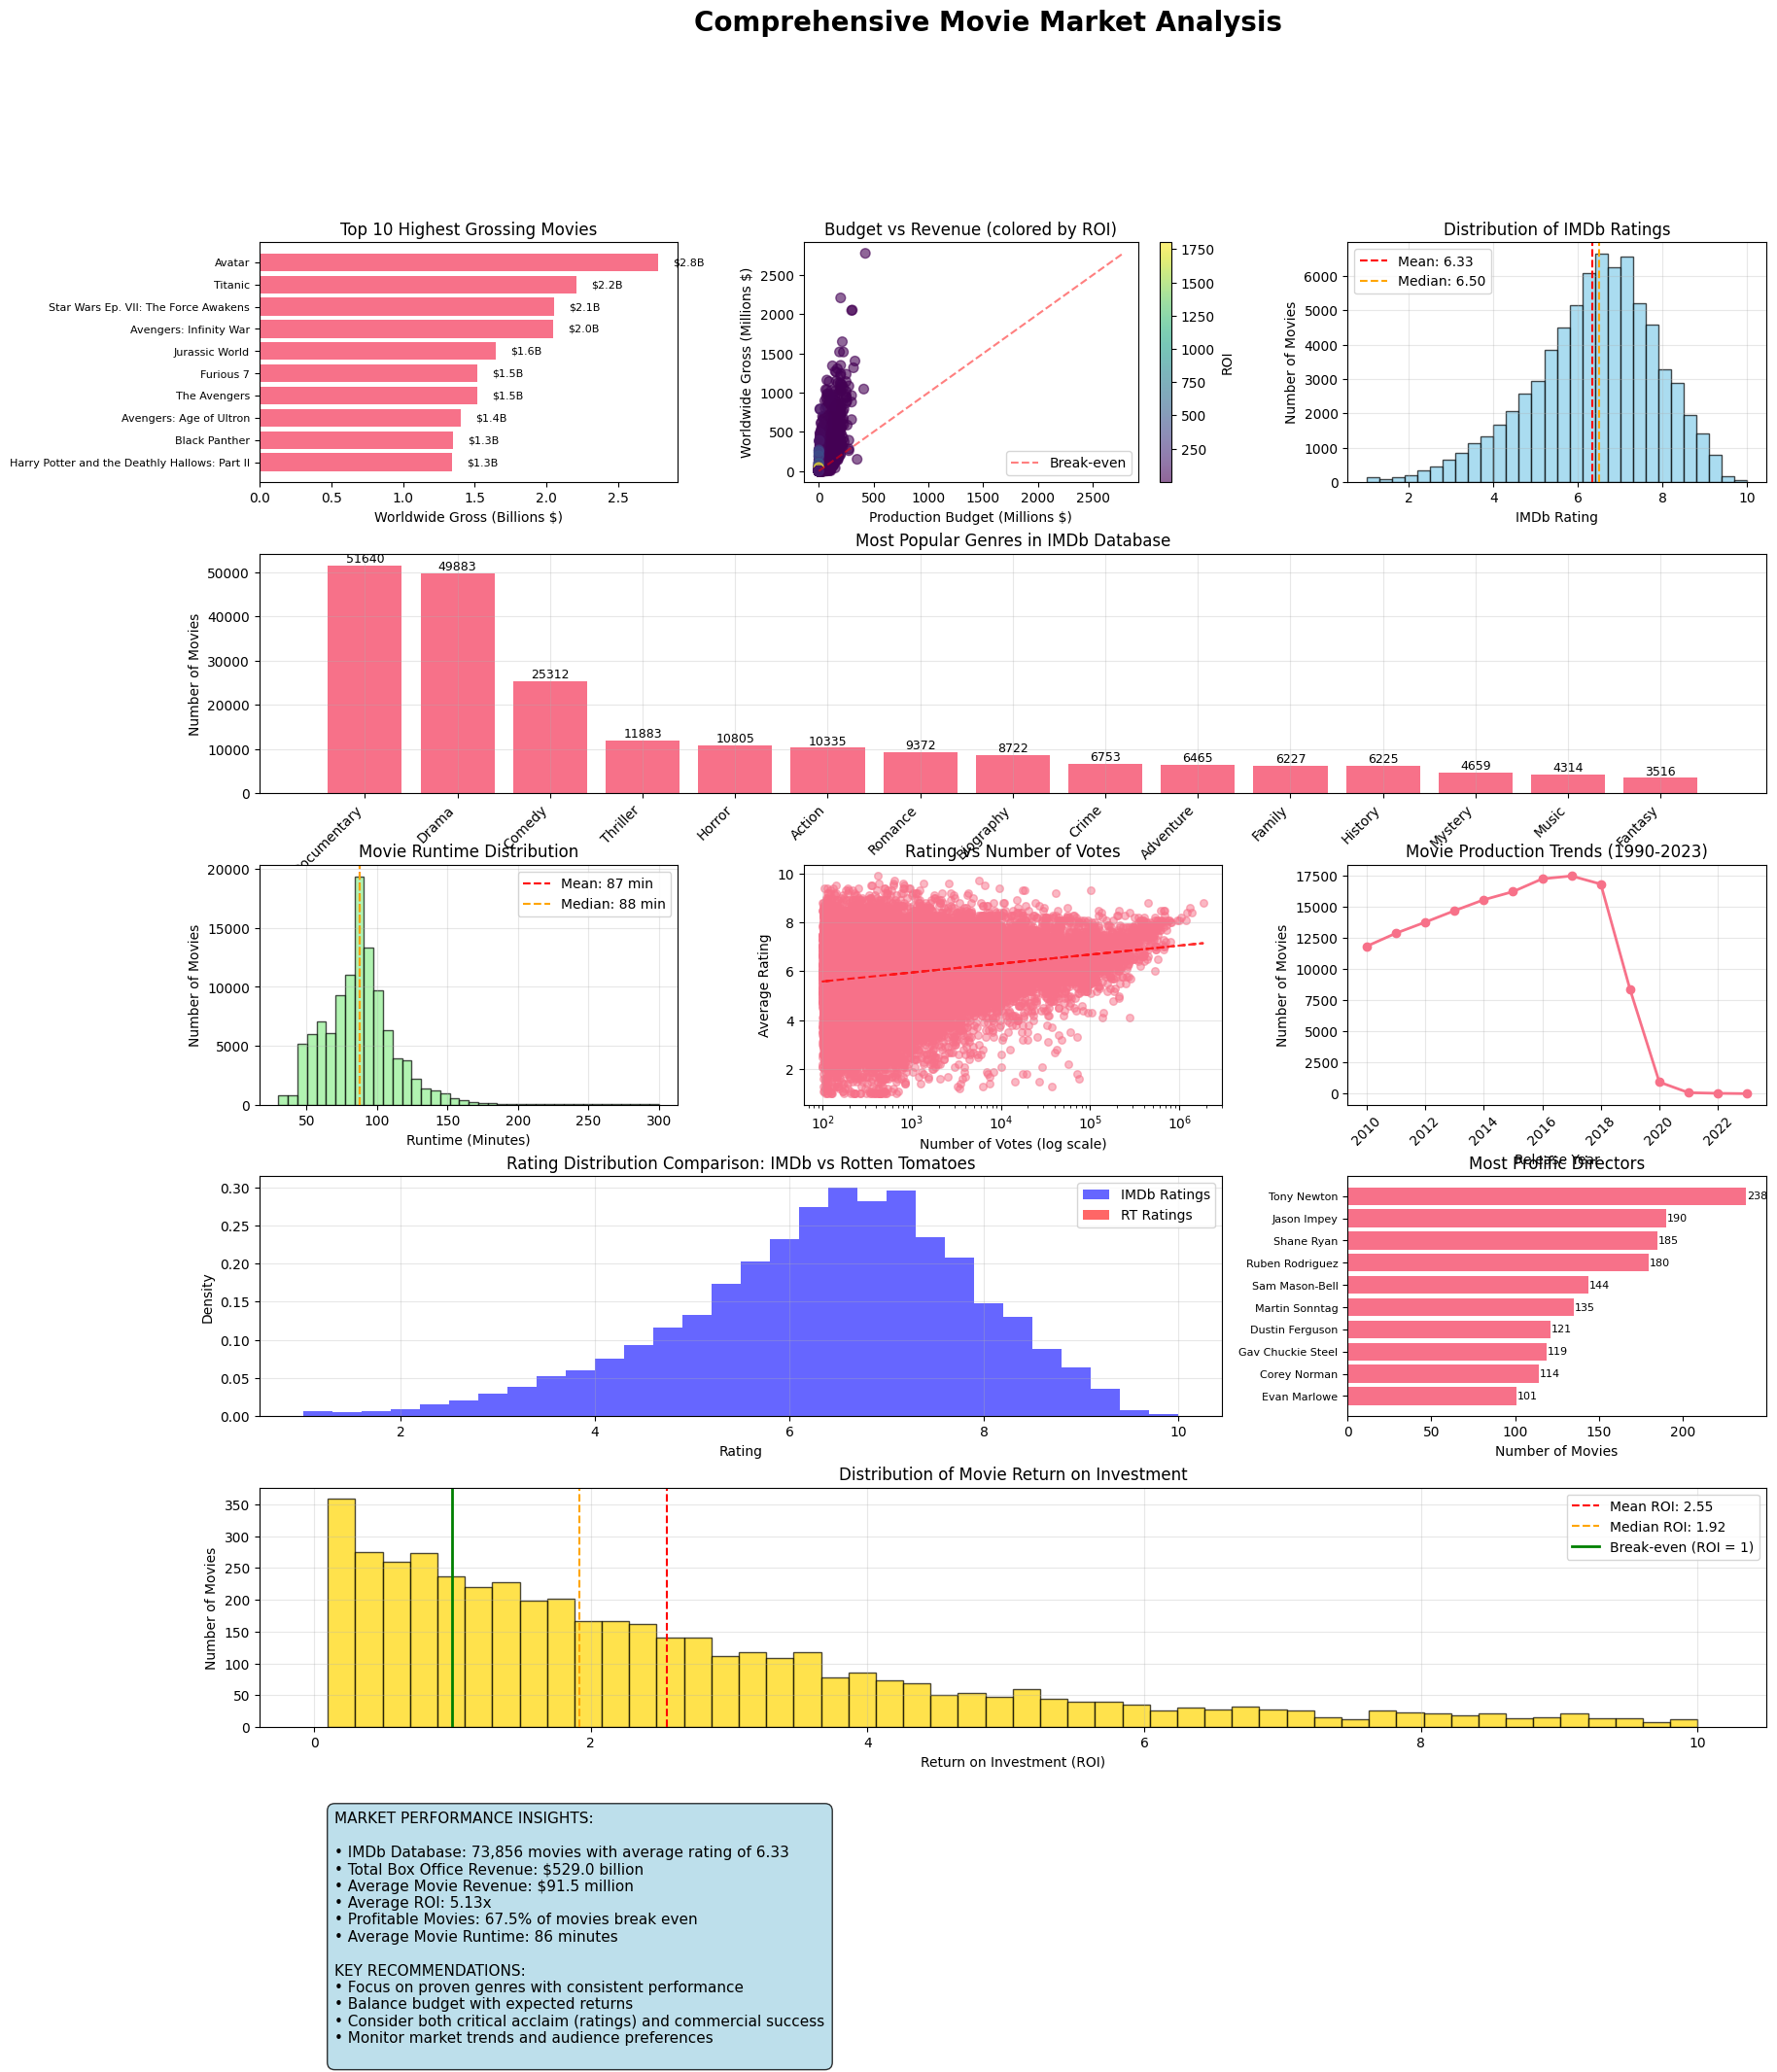

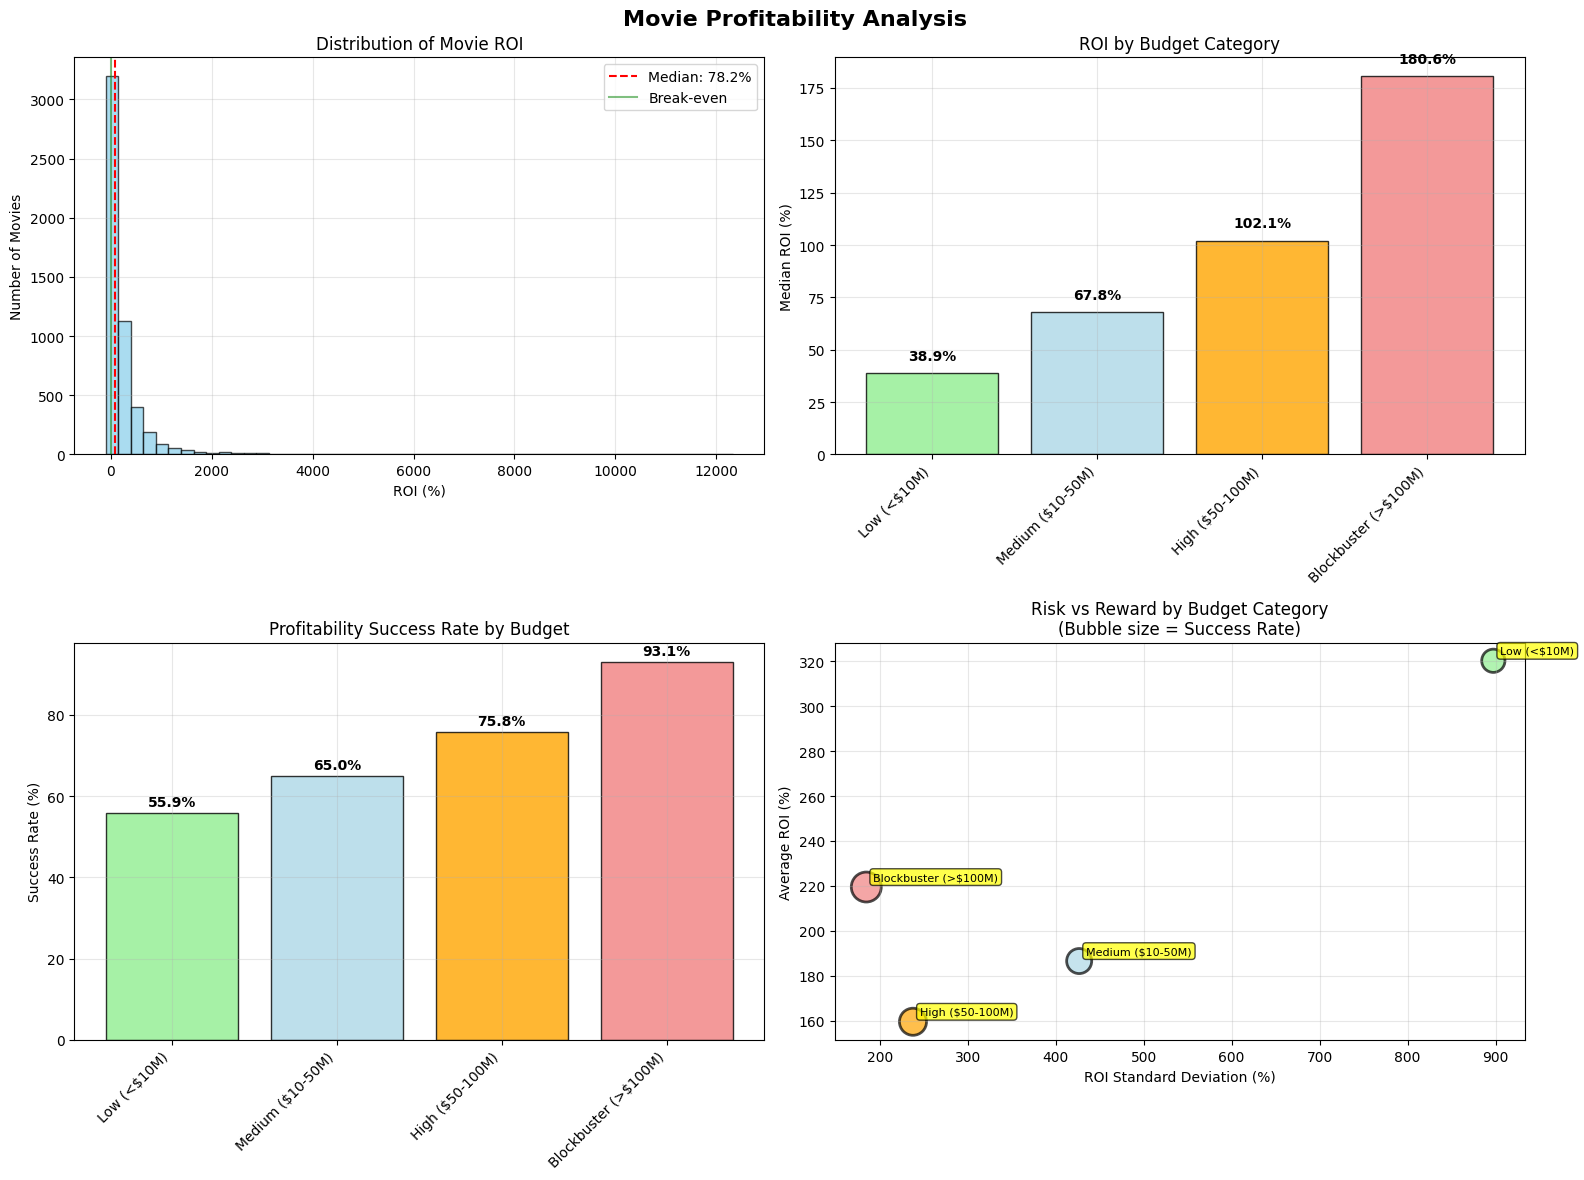

Analyzing 2316 movies with complete timing and revenue data...

Monthly Performance Analysis:
              worldwide_gross                  
                         mean      median count
release_month                                  
1                  79741383.0  30396134.0   169
2                 108373792.0  43299774.0   142
3                 106762621.0  25489102.0   212
4                  86009883.0  22594052.0   201
5                 173880133.0  41265784.0   152
6                 173130742.0  35681080.0   181
7                 180347654.0  81461343.0   159
8                  84996357.0  43833393.0   184
9                  76609807.0  30698715.0   200
10                 64312294.0  13255810.0   270
11                181826009.0  70536870.0   221
12                153635887.0  52837989.0   225


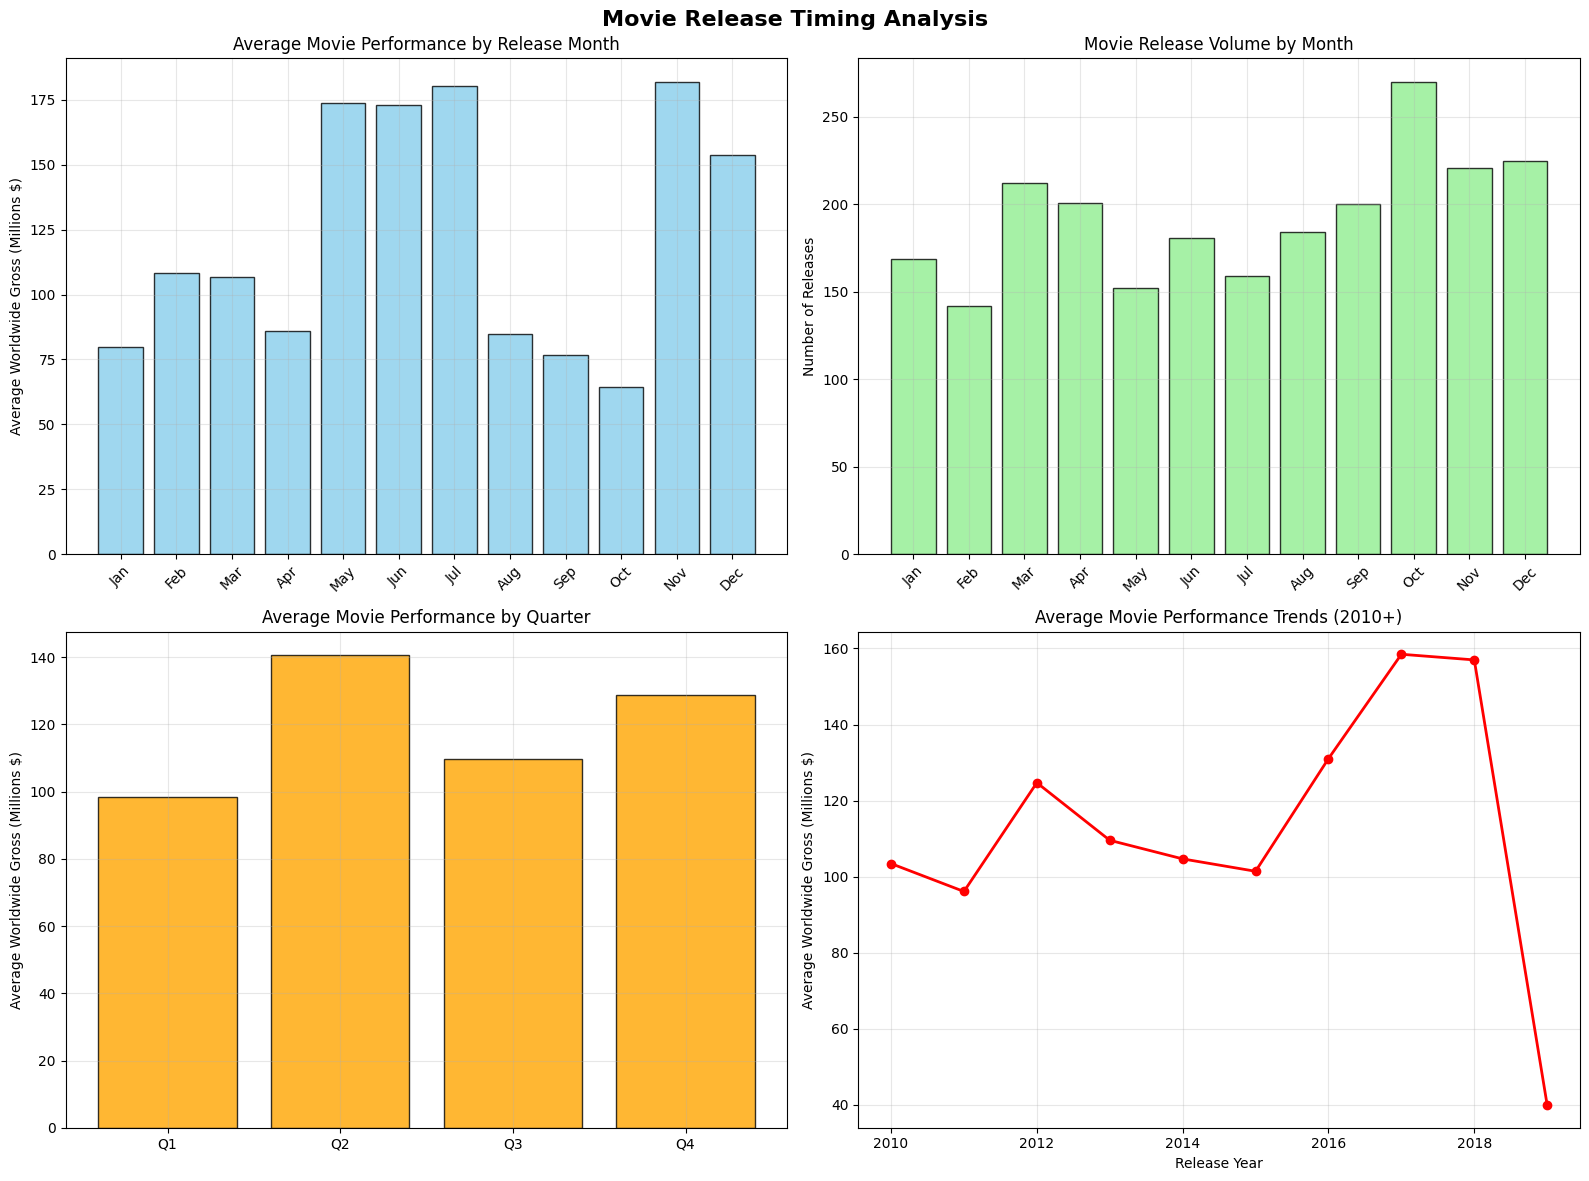

Generating recommendation dashboard...


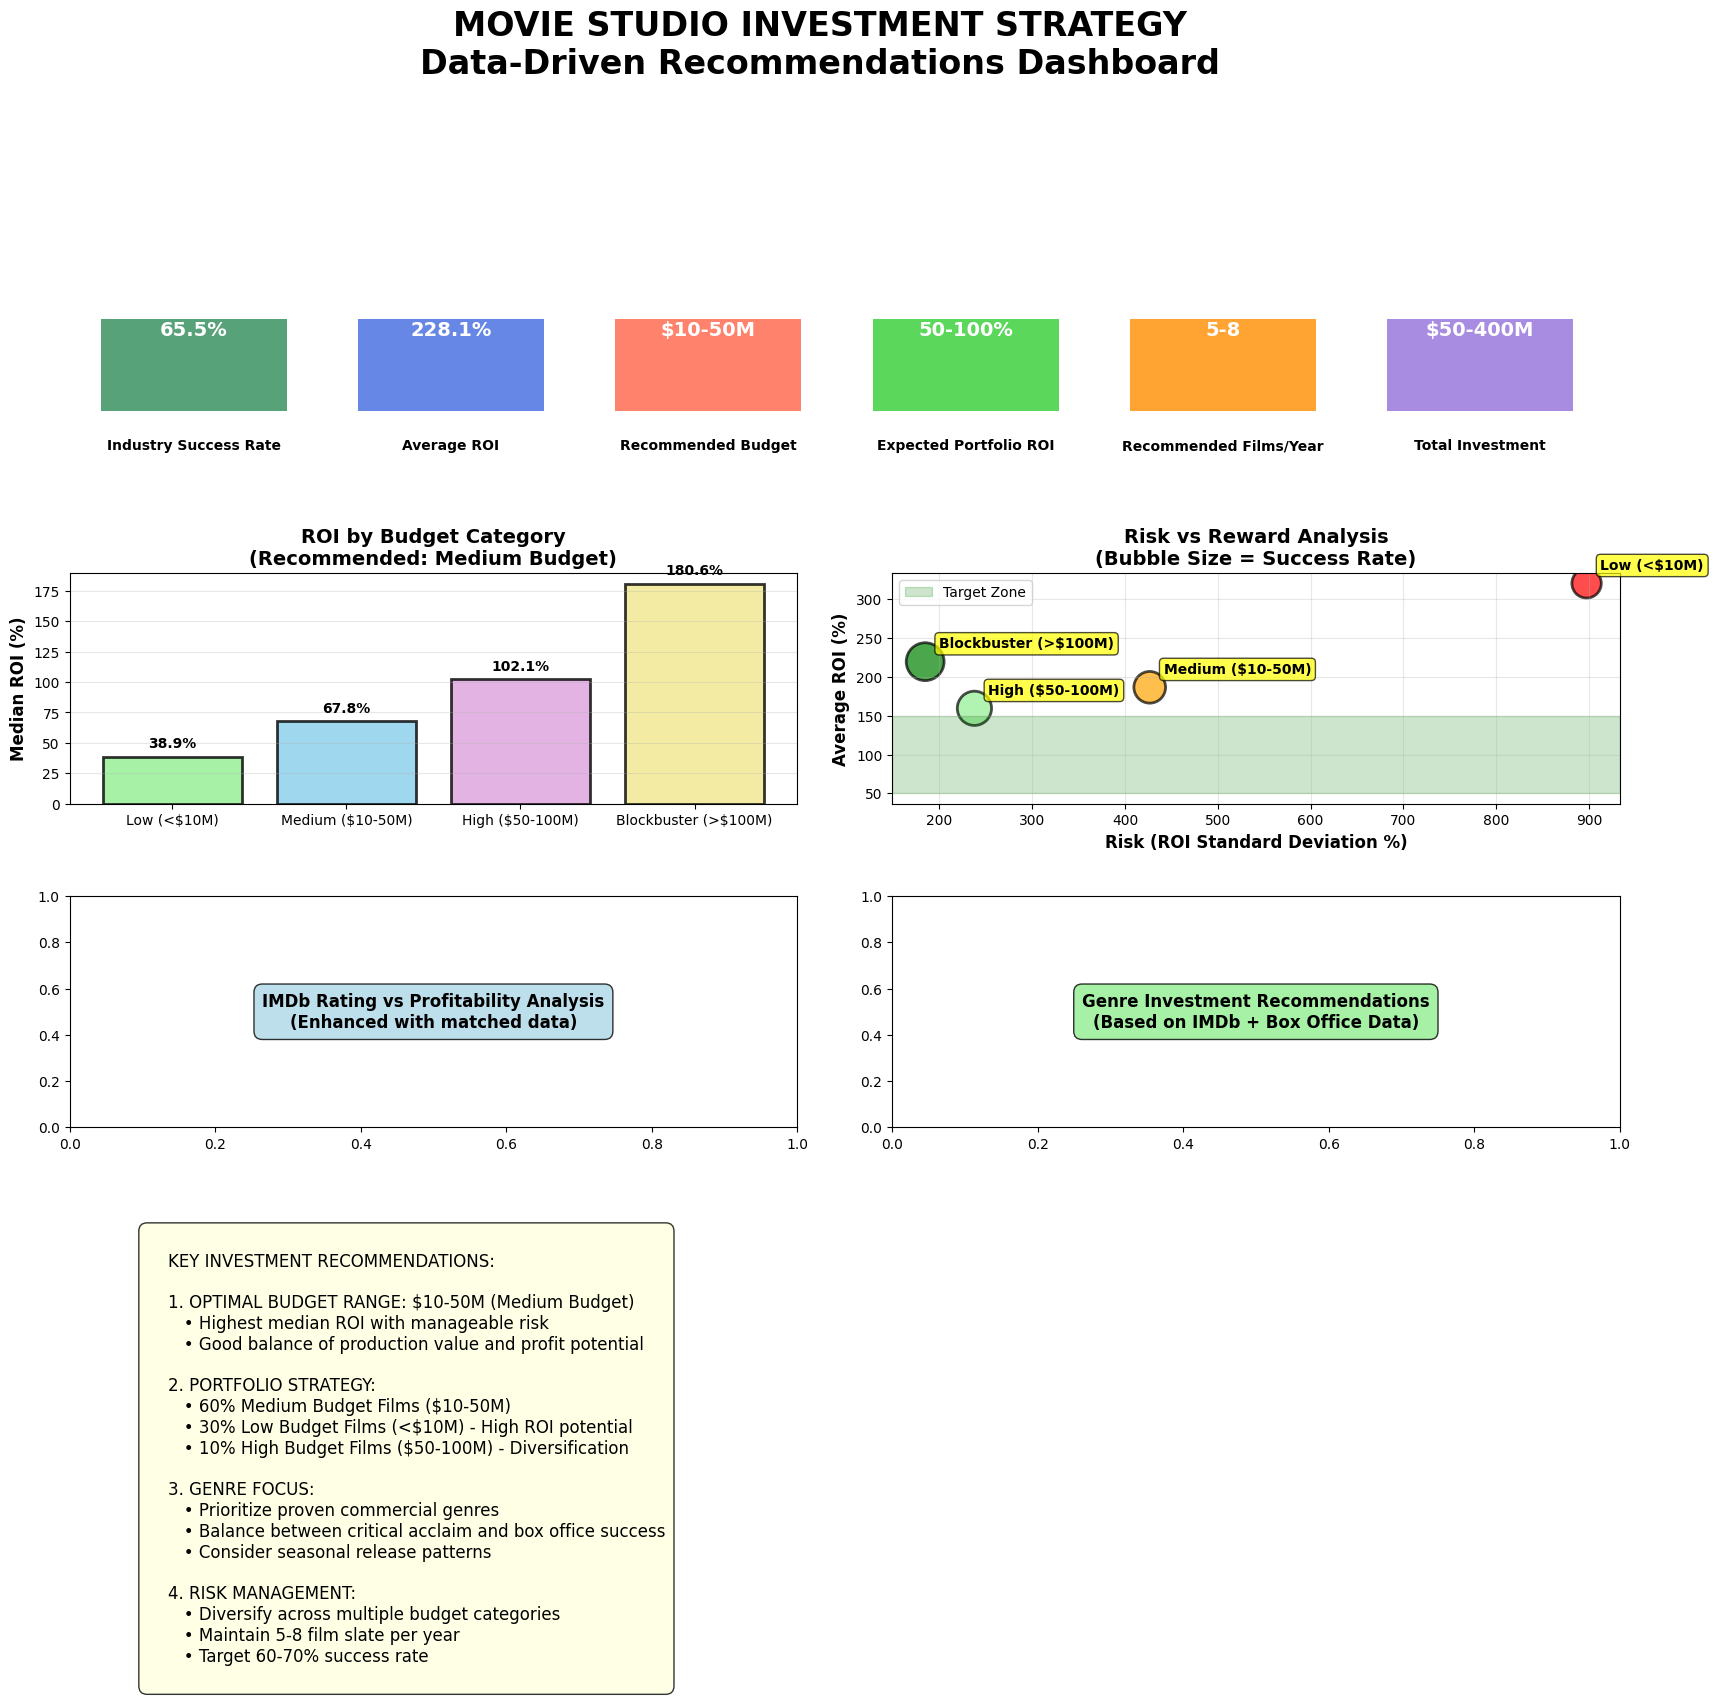

In [98]:
create_comprehensive_analysis()

profit_analysis, budget_roi, budget_stats, profitable_movies, total_movies, avg_roi = analyze_profitability_with_imdb()

market_trends = analyze_market_trends()

if profit_analysis is not None:
    print("Generating recommendation dashboard...")
    recommendation_fig = create_recommendation_dashboard(
        profit_analysis=profit_analysis,
        budget_roi=budget_roi,
        budget_stats=budget_stats,
        profitable_movies=profitable_movies,
        total_movies=total_movies,
        avg_roi=avg_roi
    )
    plt.show()